<a href="https://colab.research.google.com/github/avishek-astra/Deep_Learning_Experiments/blob/main/data_featureAugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
#import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

Create and inspect the data

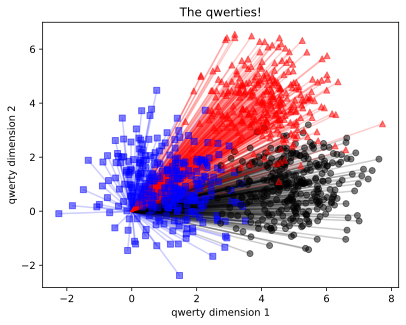

In [77]:
#create data
nPerClust=300
blur=1

A=[1,1]
B=[5,1]
C=[4,4]
#generate data
a=[A[0]+np.random.randn(nPerClust)*blur,A[1]+np.random.randn(nPerClust)*blur]
b=[B[0]+np.random.randn(nPerClust)*blur,B[1]+np.random.randn(nPerClust)*blur]
c=[C[0]+np.random.randn(nPerClust)*blur,C[1]+np.random.randn(nPerClust)*blur]
#true labels
labels_np=np.hstack((np.zeros((nPerClust)),np.ones((nPerClust)),2*np.ones((nPerClust))))
#concatanate into a matrix
data_np=np.hstack((a,b,c)).T
#convert to a pytorch tensor
data=torch.tensor(data_np).float()
labels=torch.tensor(labels_np).long() #note:'long' format for CCE
#draw distance to origin
color='bkr'
for i in range(len(data)):
  plt.plot([0,data[i,0]],[0,data[i,1]],color=color[labels[i]],alpha=.2)
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',alpha=.5)
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.title('The qwerties!')
plt.show()


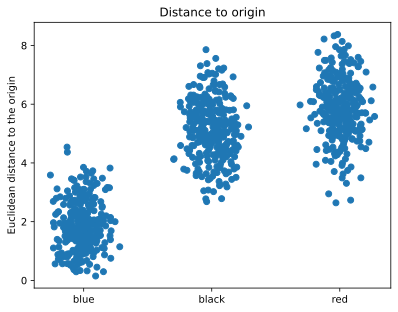

In [78]:
#compute euclidean distance to the origin
dist2origin=torch.sqrt(data[:,0]**2+data[:,1]**2)
plt.plot(labels+torch.randn(900)/10,dist2origin,'o')
plt.xticks([0,1,2],labels=['blue','black','red'])
plt.ylabel('Euclidean distance to the origin')
plt.title('Distance to origin')
plt.show()

In [79]:
#add that to the data matrix
dataAug=torch.cat((data,dist2origin.view(len(data),1)),axis=1)
#check the data sizes
print(data.shape)
print(dataAug.shape)

torch.Size([900, 2])
torch.Size([900, 3])


In [80]:
#use scikitlearn to split the data
train_data,test_data,train_labels,test_labels=train_test_split(dataAug,labels,test_size=.1)
#then convert them into pytorch datasets(note:already converted to tensors)
train_data=TensorDataset(train_data,train_labels)
test_data=TensorDataset(test_data,test_labels)
#FINALLY, translate into dataloader objects
batchsize=16
train_loader=DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader=DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [81]:
print(f'there are {len(train_loader)}batches, each with {batchsize} samples')

there are 50batches, each with 16 samples


Create and Validate the model

In [82]:
#create a class for the model
def createTheQwertyNet(useExtraFeature=False):
  class qwertyNet(nn.Module):
    def __init__(self):
      super().__init__()
      #input layer
      ### input layer
      if useExtraFeature:
        self.input = nn.Linear(3,8)
      else:
        self.input = nn.Linear(2,8)
      ##hidden layer
      self.fc1=nn.Linear(8,8)
      ##output layer
      self.output=nn.Linear(8,3)
    def forward(self,x):
      if not useExtraFeature:
        x=x[:,:2]
      x=F.relu(self.input(x))
      x=F.relu(self.fc1(x))
      x=self.output(x)
      return x
   # create the model instance
  net = qwertyNet()

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.001)

  return net,lossfun,optimizer





A FUNCTION that trains the model

In [83]:
def function2trainTheModel(useExtraFeature=False):
  #number of epochs
  numepochs=50
  #create a new model
  net,lossfun,optimizer=createTheQwertyNet(useExtraFeature)
  #initialize Losses
  losses=torch.zeros(numepochs)
  trainAcc=[]
  testAcc=[]
  #iterate over epochs
  for epochi in range(numepochs):
    #iterate over training batches
    #switch on training mode
    net.train()
    #loop over training data batches
    batchAcc=[]
    batchLoss=[]
    for X,y in train_loader:
      #forward pass and loss
      yHat=net(X)
      loss=lossfun(yHat,y)
      #backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      #loss from this batch
      batchLoss.append(loss.item())
      #compute accuracy over the training batch
      accuracyPct=100*torch.mean((torch.argmax(yHat,axis=1)==y).float())
      batchAcc.append(accuracyPct)
    #now that we have trained through the batches, get their average training accuracy
    trainAcc.append(np.mean(batchAcc))
    #and get average losses across the batches
    losses[epochi]=np.mean(batchLoss)
    #test accuracy
    net.eval()
    X,y=next(iter(test_loader)) #extract X,y from test dataLoader
    with torch.no_grad(): #deactivates autograd
      yHat=net(X)
    #compute test accuracy
    testAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()))
    #epochs
  return trainAcc,testAcc,losses,net

A function that plots the result

In [84]:
# a function that plots the results
def plotTheResults():
  #compute accuracy over entire dataset(train+test)
  yHat=net(dataAug)
  predictions=torch.argmax(yHat,axis=1)
  accuracy=(predictions==labels).float()
  totalAcc=torch.mean(100*accuracy).item()
  #and accuracy by group
  accuracyByGroup=torch.zeros(3)
  for i in range(3):
    accuracyByGroup[i]=torch.mean(100*accuracy[labels==i]).detach().item()
  #plot the figure
  fig,ax = plt.subplots(2,2,figsize=(10,6))
  #plot the losses
  ax[0,0].plot(losses.detach())
  ax[0,0].set_ylabel('Loss')
  ax[0,0].set_xlabel('epoch')
  ax[0,0].set_title('Losses')
  #plot the accuracy function
  ax[0,1].plot(trainAcc,label='Train')
  ax[0,1].plot(testAcc,label='Test')
  ax[0,1].set_ylabel('Accuracy (%)')
  ax[0,1].set_xlabel('Epoch')
  ax[0,1].set_title(' Accuracy')
  ax[0,1].legend()
  #plot overall accuracy by group
  ax[1,0].bar(range(3),accuracyByGroup)
  ax[1,0].set_ylim([torch.min(accuracyByGroup)-5,torch.max(accuracyByGroup)+5])
  ax[1,0].set_xticks([0,1,2])
  ax[1,0].set_xlabel('Group')
  ax[1,0].set_ylabel('Accuracy (%)')
  ax[1,0].set_title('Accuracy by gorup')
  #scatterplot of correct and incorrect labeled data
  colorShapes=['bs','ko','g^'] #data markers
  for i in range(3):
    ax[1,1].plot(data[labels==i,0],data[labels==i,1],colorShapes[i],alpha=.5,label=f'Group {i}')
    #cross out the incorrect ones
    idxErr=(accuracy==0)&(labels==i)
    ax[1,1].plot(data[idxErr,0],data[idxErr,1],'rx')
  ax[1,1].set_title('All groups')
  ax[1,1].set_xlabel('qwerty dimension 1')
  ax[1,1].set_ylabel('qwerty dimension 2')
  ax[1,1].legend()
  plt.show()



Test the model with and without the additional feature

Final accuracy:80.00%


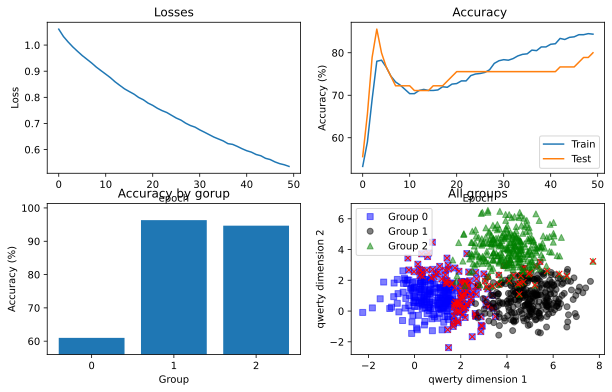

In [85]:
#run the model and visualize the results
trainAcc,testAcc,losses,net=function2trainTheModel(useExtraFeature=False)
print("Final accuracy:%.2f%%"%testAcc[-1].item())
plotTheResults()


Final accuracy:75.56%


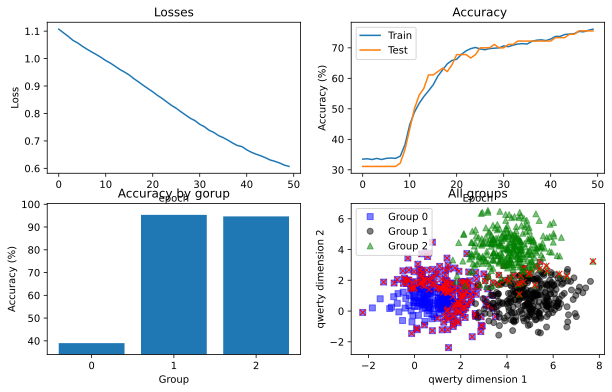

In [86]:
#run the model and visualize the results
trainAcc,testAcc,losses,net=function2trainTheModel(useExtraFeature=True)
print("Final accuracy:%.2f%%"%testAcc[-1].item())
plotTheResults()


In [87]:
#Run the experiment multiple times and do a t-test!
finalacc2 = np.zeros(10)
finalacc3 = np.zeros(10)

for i in range(10):
  finalacc2[i] = function2trainTheModel(False)[1][-1]
  finalacc3[i] = function2trainTheModel(True)[1][-1]

# show the numbers
print( np.round(np.vstack((finalacc2,finalacc3)).T,2) )

# run the t-test and print the results
from scipy import stats
t,p = stats.ttest_ind(finalacc3,finalacc2)
print('\n\nt=%.2f, p=%.2f' %(t,p))


[[71.11 71.11]
 [76.67 47.78]
 [64.44 81.11]
 [67.78 85.56]
 [43.33 84.44]
 [43.33 80.  ]
 [81.11 66.67]
 [83.33 67.78]
 [67.78 53.33]
 [63.33 70.  ]]


t=0.77, p=0.45
